In [1]:
import os
import torch
import splitfolders
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import torchinfo
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

%matplotlib inline

from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
input_dir = "Lab1\simpsons_dataset"
PATH = "Lab1\data"

#splitfolders.ratio(input_dir, output=PATH,seed=1332, ratio=(.6, 0.2,0.2))

image_size = (64, 64, 3)
epochs = 10
classes = os.listdir(input_dir)
print(len(classes))
print((classes))

42
['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [3]:
def image_shower(images, labels, n):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image / 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%6s' % classes[label] for label in labels[:n]))
    
transform = transforms.Compose(
    [transforms.Resize((64,64)), 
     transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) #поиграть, посмотреть на что влияет brg

In [4]:
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"),
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=100,
                                          num_workers=0,
                                          shuffle=True)


valset = torchvision.datasets.ImageFolder(os.path.join(PATH, "val"),
                                           transform=transform)
valloader = torch.utils.data.DataLoader(valset,
                                         batch_size=50,
                                         num_workers=0,
                                         shuffle=True)


testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"),
                                           transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=50,
                                         num_workers=0,
                                         shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Labels:  ned_flanders apu_nahasapeemapetilon homer_simpson mayor_quimby


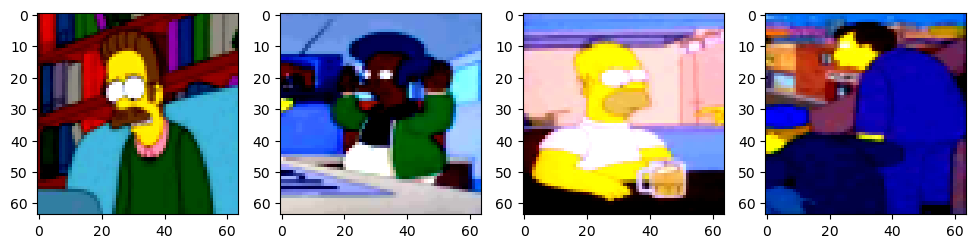

In [5]:
images, labels = next(iter(trainloader))
image_shower(images, labels,4)

In [6]:
#import Augmentor

#p = Augmentor.Pipeline("Lab1/data/train/troy_mcclure")

#p.flip_left_right(0.5)
#p.rotate(0.3, 10, 10)
#p.skew(0.4, 0.5)
#p.random_distortion(probability=1, grid_width=64, grid_height=64, magnitude=3)
#p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
#p.sample(50)

In [7]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.require = False

model.fc = nn.Linear(512, 42)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

print(torchinfo.summary(model, input_size=(100, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [100, 42]                 --
├─Conv2d: 1-1                            [100, 64, 32, 32]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 32, 32]         128
├─ReLU: 1-3                              [100, 64, 32, 32]         --
├─MaxPool2d: 1-4                         [100, 64, 16, 16]         --
├─Sequential: 1-5                        [100, 64, 16, 16]         --
│    └─BasicBlock: 2-1                   [100, 64, 16, 16]         --
│    │    └─Conv2d: 3-1                  [100, 64, 16, 16]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 16, 16]         128
│    │    └─ReLU: 3-3                    [100, 64, 16, 16]         --
│    │    └─Conv2d: 3-4                  [100, 64, 16, 16]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 16, 16]         128
│    │    └─ReLU: 3-6                    [100, 64, 16, 16]         --
│

In [8]:
train_losses = []
val_losses= []

for epoch in range(epochs):
    train_loss, val_loss, correct_train, correct_val = 0, 0, 0, 0
    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        prediction = outputs.max(dim=1, keepdim=True)[1]
        correct_train += prediction.eq(labels.view_as(prediction)).sum()
    
    with torch.no_grad():#почему?....
        model.eval()
        for i, data in tqdm(enumerate(valloader, 0)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            prediction = outputs.max(dim=1, keepdim=True)[1]
            correct_val += prediction.eq(labels.view_as(prediction)).sum()

    train_loss/=len(trainloader)
    val_loss/=len(valloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    
    print ("Epoch {} - Train loss: {} ".format(epoch+1, train_loss))
    print ("Epoch {} - Val loss: {} ".format(epoch+1, val_loss))

132it [02:54,  1.32s/it]
84it [00:33,  2.48it/s]


Epoch 1 - Train loss: 2.753773500521978 
Epoch 1 - Val loss: 1.9149184610162462 


132it [02:41,  1.23s/it]
84it [00:31,  2.66it/s]


Epoch 2 - Train loss: 1.4322390980792767 
Epoch 2 - Val loss: 2.0547984015373957 


132it [02:36,  1.19s/it]
84it [00:25,  3.30it/s]


Epoch 3 - Train loss: 1.1853441029022427 
Epoch 3 - Val loss: 1.0563872868106479 


132it [02:28,  1.13s/it]
84it [00:25,  3.35it/s]


Epoch 4 - Train loss: 0.5601915520652861 
Epoch 4 - Val loss: 0.8277855487096877 


132it [02:27,  1.12s/it]
84it [00:24,  3.39it/s]


Epoch 5 - Train loss: 0.29580657133324406 
Epoch 5 - Val loss: 0.8245747454819226 


132it [02:33,  1.16s/it]
84it [00:26,  3.18it/s]


Epoch 6 - Train loss: 0.15281334025503107 
Epoch 6 - Val loss: 0.8937432153948716 


132it [02:52,  1.31s/it]
84it [00:32,  2.62it/s]


Epoch 7 - Train loss: 0.07953996472342899 
Epoch 7 - Val loss: 1.0450683392229534 


132it [03:04,  1.40s/it]
84it [00:29,  2.84it/s]


Epoch 8 - Train loss: 0.13372907495817565 
Epoch 8 - Val loss: 0.9349564358237243 


132it [03:28,  1.58s/it]
84it [00:30,  2.76it/s]


Epoch 9 - Train loss: 0.021070107872329765 
Epoch 9 - Val loss: 1.0420019669192178 


132it [03:23,  1.54s/it]
84it [00:26,  3.19it/s]


Epoch 10 - Train loss: 0.01570127622901716 
Epoch 10 - Val loss: 1.0089577872838293 


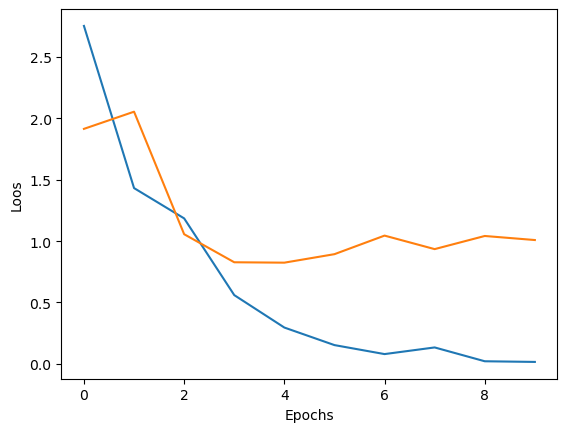

In [9]:
plt.plot([i for i in range(0, epochs)], train_losses)
plt.plot([i for i in range(0, epochs)], val_losses)
plt.ylabel('Loos')
plt.xlabel('Epochs')
plt.show()
#синяя train, оранжевая val

In [10]:
class_correct = list(0. for i in range(42))
class_total = list(0. for i in range(42))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                class_correct[label] += 1
            class_total[label] += 1


for i in range(42):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of abraham_grampa_simpson : 80 %
Accuracy of agnes_skinner : 22 %
Accuracy of apu_nahasapeemapetilon : 92 %
Accuracy of barney_gumble : 27 %
Accuracy of bart_simpson : 91 %
Accuracy of carl_carlson : 66 %
Accuracy of charles_montgomery_burns : 76 %
Accuracy of chief_wiggum : 91 %
Accuracy of cletus_spuckler : 60 %
Accuracy of comic_book_guy : 75 %
Accuracy of disco_stu :  0 %
Accuracy of edna_krabappel : 79 %
Accuracy of fat_tony : 66 %
Accuracy of   gil : 33 %
Accuracy of groundskeeper_willie : 76 %
Accuracy of homer_simpson : 86 %
Accuracy of kent_brockman : 89 %
Accuracy of krusty_the_clown : 89 %
Accuracy of lenny_leonard : 77 %
Accuracy of lionel_hutz : 50 %
Accuracy of lisa_simpson : 86 %
Accuracy of maggie_simpson : 44 %
Accuracy of marge_simpson : 91 %
Accuracy of martin_prince : 40 %
Accuracy of mayor_quimby : 64 %
Accuracy of milhouse_van_houten : 84 %
Accuracy of miss_hoover :  0 %
Accuracy of moe_szyslak : 85 %
Accuracy of ned_flanders : 89 %
Accuracy of nelson_mun

In [11]:
#точность
correct = 0
total = 0

recall = MulticlassRecall(num_classes=42, average=None)
precision = MulticlassPrecision(num_classes=42, average=None)
recall.to(device)
precision.to(device)

with torch.no_grad():
    model.eval()
    for data in testloader:
        inputs = data[0].to(device)
        labels = data[1].to(device)
        outputs = model(inputs)
        __, predicted = torch.max(outputs.data, 1)
        recall.update(outputs, labels)
        precision.update(outputs, labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f"Accuracy: {100 * correct/total:.0f}%")
reca = sum(recall.compute())/42*100
preci = sum(precision.compute())/42*100
f1 = 2 * ((reca*preci)/(reca+preci))
print(f'Recall: {reca:.2f}%\nPrecision: {preci:.2f}% \nF1: {f1:.2f}%')

Accuracy: 84%
Recall: 65.53%
Precision: 71.21% 
F1: 68.25%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Real Labels:  lisa_simpson abraham_grampa_simpson ned_flanders marge_simpson homer_simpson
Predicted:  lisa_simpson abraham_grampa_simpson ned_flanders marge_simpson homer_simpson


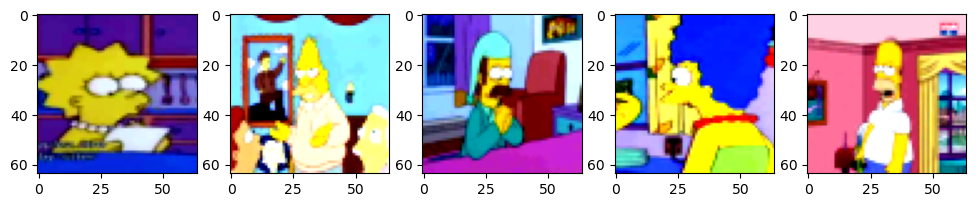

In [13]:
images, labels = next(iter(testloader))
image_shower(images, labels,5)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:5]))